In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gym

from drl.ddpg import DDPG
from utils import Params, set_logger, create_experiment_folder

PATH_PROJECT = Path.cwd().parent
PATH_RESULTS = PATH_PROJECT / 'results'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # don't use GPU
plt.style.use('seaborn')

# Set seed
np.random.seed(123)
if tf.__version__[0] == '2': # tensorflow 2
#     tf.compat.v1.disable_eager_execution() # otherwise very slow
    tf.random.set_seed(123) # needs to be after the previous line
else: # tensorflow 1
    tf.set_random_seed(123)

# Initialize

In [2]:
# read parameters
params = Params('drl/ddpg_params.json')
params.environment_name = 'LunarLanderContinuous-v2'

# create folder to save results and parameters
path_results_exp = create_experiment_folder(PATH_RESULTS, params.environment_name, params.agent_name)
params.save(path_results_exp / 'params.json')

# log files
monitor_train = pd.DataFrame(columns=['reward'])
monitor_train.index.name = 'train_episode'
monitor_train.to_csv(path_results_exp / 'monitor_train.csv')

monitor_test = pd.DataFrame(columns=['reward'])
monitor_test.index.name = monitor_train.index.name
monitor_test.to_csv(path_results_exp / 'monitor_test.csv')


# ENVIRONMENT
env = gym.make(params.environment_name)
env.seed(params.env_options['seed'])
env.reset()


# AGENT
nb_train_steps = params.training['nb_train_steps']
eval_every_n_steps = params.training['eval_every_n_steps']
nb_eval_steps = params.training['nb_eval_steps']

agent = DDPG(env, 
             neurons_per_layer=params.DDPG['neurons_per_layer'], 
             replay_memory_max_size=params.DDPG['buffer_size'], 
             discount_factor=params.DDPG['gamma'],
             L2_coeff=params.DDPG['L2_coeff'],
             LR_critic=params.DDPG['LR_critic'],
             LR_actor=params.DDPG['LR_actor'])

# Train

In [3]:
%%time
nb_train_steps = params.training['nb_train_steps']
eval_every_n_steps = params.training['eval_every_n_steps']
nb_eval_steps = params.training['nb_eval_steps']

print('Start training')
train_episode = 0
for i in range(nb_train_steps // eval_every_n_steps):
    
    # Train
    list_total_reward_train = agent.train(env, 
                                          nb_training_steps=eval_every_n_steps, 
                                          minibatch_size=params.DDPG['batch_size'], 
                                          tau_update_target=params.DDPG['tau_update_target'],
                                          warmup_steps=params.DDPG['warmup_steps'])
    train_episodes_idx = np.arange(train_episode, train_episode+len(list_total_reward_train))
    train_episode += len(list_total_reward_train)

    # Test
    list_total_reward_test = agent.test(env, nb_testing_steps=nb_eval_steps)
    average_test_reward = np.mean(list_total_reward_test)
    print('{} training episodes done ; average train reward is {:.1f} ; average test reward is {:.1f}'.format(
        train_episode, np.mean(list_total_reward_train), average_test_reward))

    # Save results
    monitor_train = pd.DataFrame({'reward': list_total_reward_train}, index=train_episodes_idx)
    monitor_train.to_csv(path_results_exp / 'monitor_train.csv', mode='a', header=None)
    monitor_test = pd.DataFrame({'reward': [average_test_reward]}, index=[train_episodes_idx[-1]])
    monitor_test.to_csv(path_results_exp / 'monitor_test.csv', mode='a', header=None)

print('Training finished')

Start training
13 training episodes done ; average train reward is -450.9 ; average test reward is -122.3
27 training episodes done ; average train reward is -178.7 ; average test reward is -172.4
41 training episodes done ; average train reward is -140.9 ; average test reward is -121.4
55 training episodes done ; average train reward is -131.3 ; average test reward is -192.7
66 training episodes done ; average train reward is -128.3 ; average test reward is -119.7
71 training episodes done ; average train reward is -157.6 ; average test reward is -258.6
75 training episodes done ; average train reward is -188.6 ; average test reward is -184.3
78 training episodes done ; average train reward is -214.9 ; average test reward is -291.2
83 training episodes done ; average train reward is -281.1 ; average test reward is -287.4
85 training episodes done ; average train reward is -251.8 ; average test reward is -258.7
87 training episodes done ; average train reward is -225.9 ; average test r

# Display results

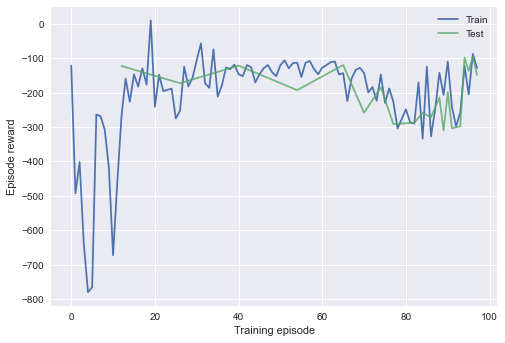

In [4]:
monitor_train = pd.read_csv(path_results_exp / 'monitor_train.csv', index_col=0)
monitor_test = pd.read_csv(path_results_exp / 'monitor_test.csv', index_col=0)

plt.figure()
plt.plot(monitor_train['reward'], label='Train')
plt.plot(monitor_test['reward'], label='Test', alpha=0.8)
plt.legend()
plt.xlabel('Training episode')
plt.ylabel('Episode reward')
plt.savefig(path_results_exp / 'training_curve.png', transparent=False)

In [5]:
# nb_training_ep = 100
# episode_steps = 200
# nb_training_steps = nb_training_ep * episode_steps
# test_every_n_ep = 5
# nb_testing_steps = 10 * episode_steps

# list_train_rewards = []
# list_test_rewards = []
# for i in range(nb_training_ep//test_every_n_ep):
#     print(i)

#     r_train = ddpg.train(env, test_every_n_ep*episode_steps)
#     list_train_rewards.append(r_train)
    
#     r_test = ddpg.test(env, nb_testing_steps)
#     list_test_rewards.append(r_test)
#     print()

# train_rewards = np.array(list_train_rewards).flatten()
# test_rewards = np.mean(list_test_rewards, axis=1)

# plt.figure()
# plt.plot(train_rewards)
# plt.plot(np.arange(0, len(train_rewards), test_every_n_ep), test_rewards)